In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm
from urllib.parse import urlparse
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)
from seaborn import (
    heatmap,
    barplot,
    countplot,
    set_style,
    color_palette,
    set_palette,
    histplot
)

In [2]:
warnings.filterwarnings("ignore")

def get_gradient_palette(cmap, n_colors):
    return [cmap(i/n_colors) for i in range(n_colors)]

colors = ["#fd7e14", "#495057"]
gradient_cmap = LinearSegmentedColormap.from_list("orange_black_grad", colors, N=256)

set_style("whitegrid")
palette = color_palette("rocket");

In [4]:
train = pd.read_csv("train.csv")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     64000 non-null  object
 1   result  64000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1000.1+ KB


In [6]:
train.describe()

,result
count,64000.000000
mean,0.374797
std,0.484074
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
train.head()

,url,result
0,https://caseforpages1885777.web.app/,1
1,https://www.tu-auto.com/,0
2,http://www.bancm.co/desbloqueos/USERscis=login...,1
3,https://doccomo.ne.uqag.xyz,1
4,http://academics.smcvt.edu/sburks/Definition_s...,0


In [8]:
train.shape

(64000, 2)

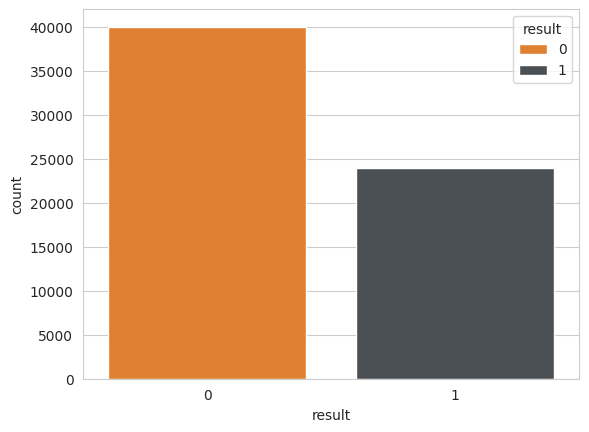

In [9]:
countplot(data=pd.DataFrame(train), x="result", palette=colors, hue="result");

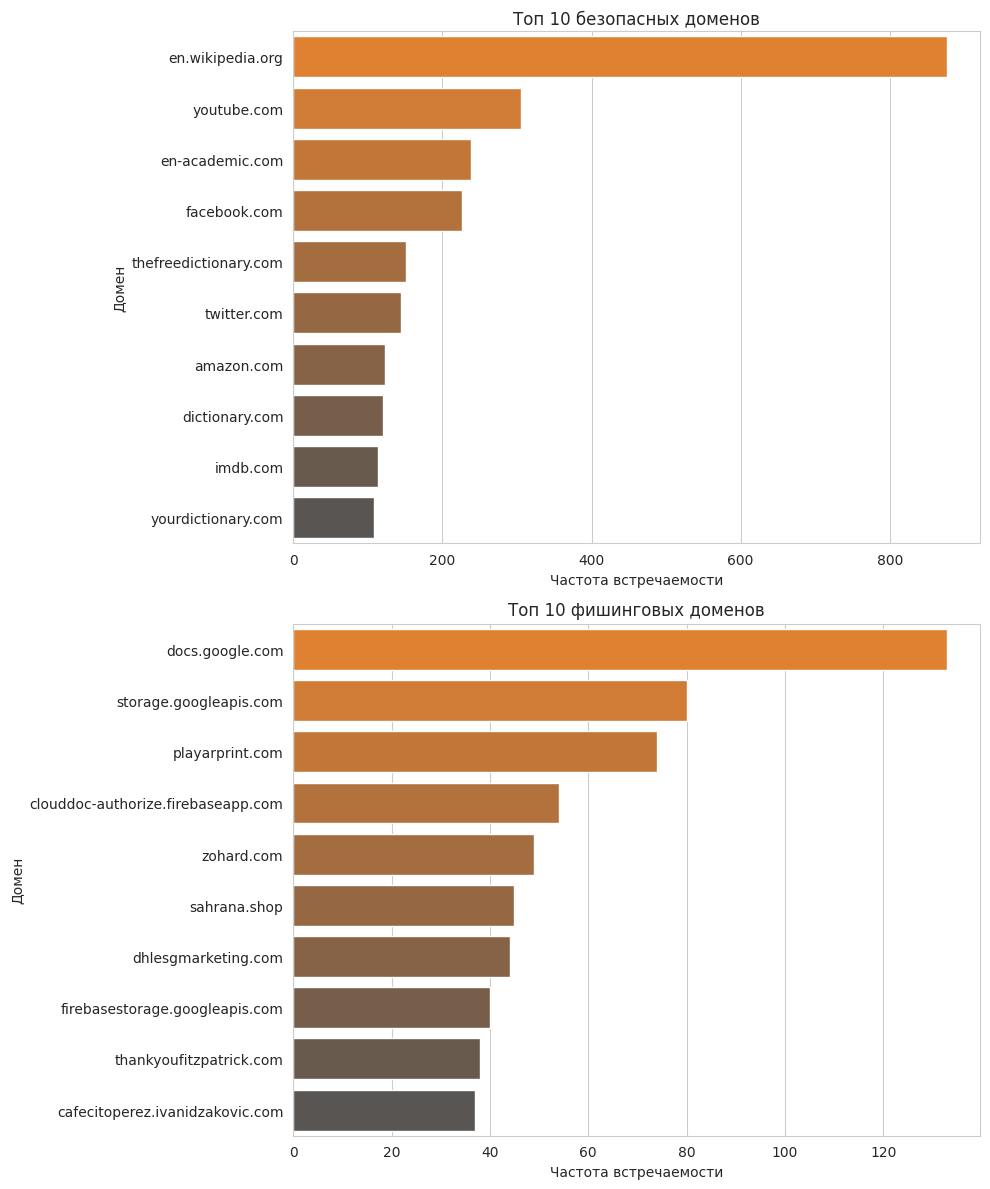

In [10]:
def extract_domain(url):
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        pass


train['domain'] = train['url'].apply(extract_domain)

top_domains_0 = train[train['result'] == 0]['domain'].value_counts().head(10)
top_domains_1 = train[train['result'] == 1]['domain'].value_counts().head(10)

gradient_palette_0 = get_gradient_palette(gradient_cmap, len(top_domains_0))
gradient_palette_1 = get_gradient_palette(gradient_cmap, len(top_domains_1))

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

barplot(x=top_domains_0.values, y=top_domains_0.index, ax=axes[0], palette=gradient_palette_0, orient='h')
axes[0].set_title('Топ 10 безопасных доменов')
axes[0].set_xlabel('Частота встречаемости')
axes[0].set_ylabel('Домен')

barplot(x=top_domains_1.values, y=top_domains_1.index, ax=axes[1], palette=gradient_palette_1, orient='h')
axes[1].set_title('Топ 10 фишинговых доменов')
axes[1].set_xlabel('Частота встречаемости')
axes[1].set_ylabel('Домен')

plt.tight_layout()
plt.show()

In [11]:
X = train["url"]
y = train["result"]

In [12]:
def parse_url_features(urls):
    results = []
    for url in tqdm(urls):
        parsed_url = urlparse(url)
        features = {}

        features['length'] = len(url)
        features['num_subdomains'] = parsed_url.netloc.count('.')
        features['num_dots'] = url.count('.')
        features['is_https'] = 1 if parsed_url.scheme == 'https' else 0
        features['path_length'] = len(parsed_url.path)
        features['special_chars'] = 1 if any(char in url for char in ['#', '%', '&', '*']) else 0
        features['has_query'] = 1 if parsed_url.query else 0
        features['count_numbers'] = sum(c.isdigit() for c in url)
        features['has_php_or_html'] = 1 if 'php' in parsed_url.path or 'html' in parsed_url.path else 0
        features['has_xyz'] = 1 if parsed_url.netloc.split('.')[-1] == 'xyz' else 0
        features['has_port'] = 1 if any(char in url.split('//')[-1] for char in [':']) else 0
        features['path_count'] = parsed_url.path.count('/')
        features['has_digit_in_netloc'] = 1 if sum(c.isdigit() for c in parsed_url.netloc) > 0 else 0
        features['netloc_is_ip'] = 1 if not (any(c.isalpha() for c in parsed_url.netloc)) else 0
        results.append(features)

    return pd.DataFrame(results)

features_dataframe = parse_url_features(X.to_list())

100%|██████████| 64000/64000 [00:01<00:00, 42422.74it/s]


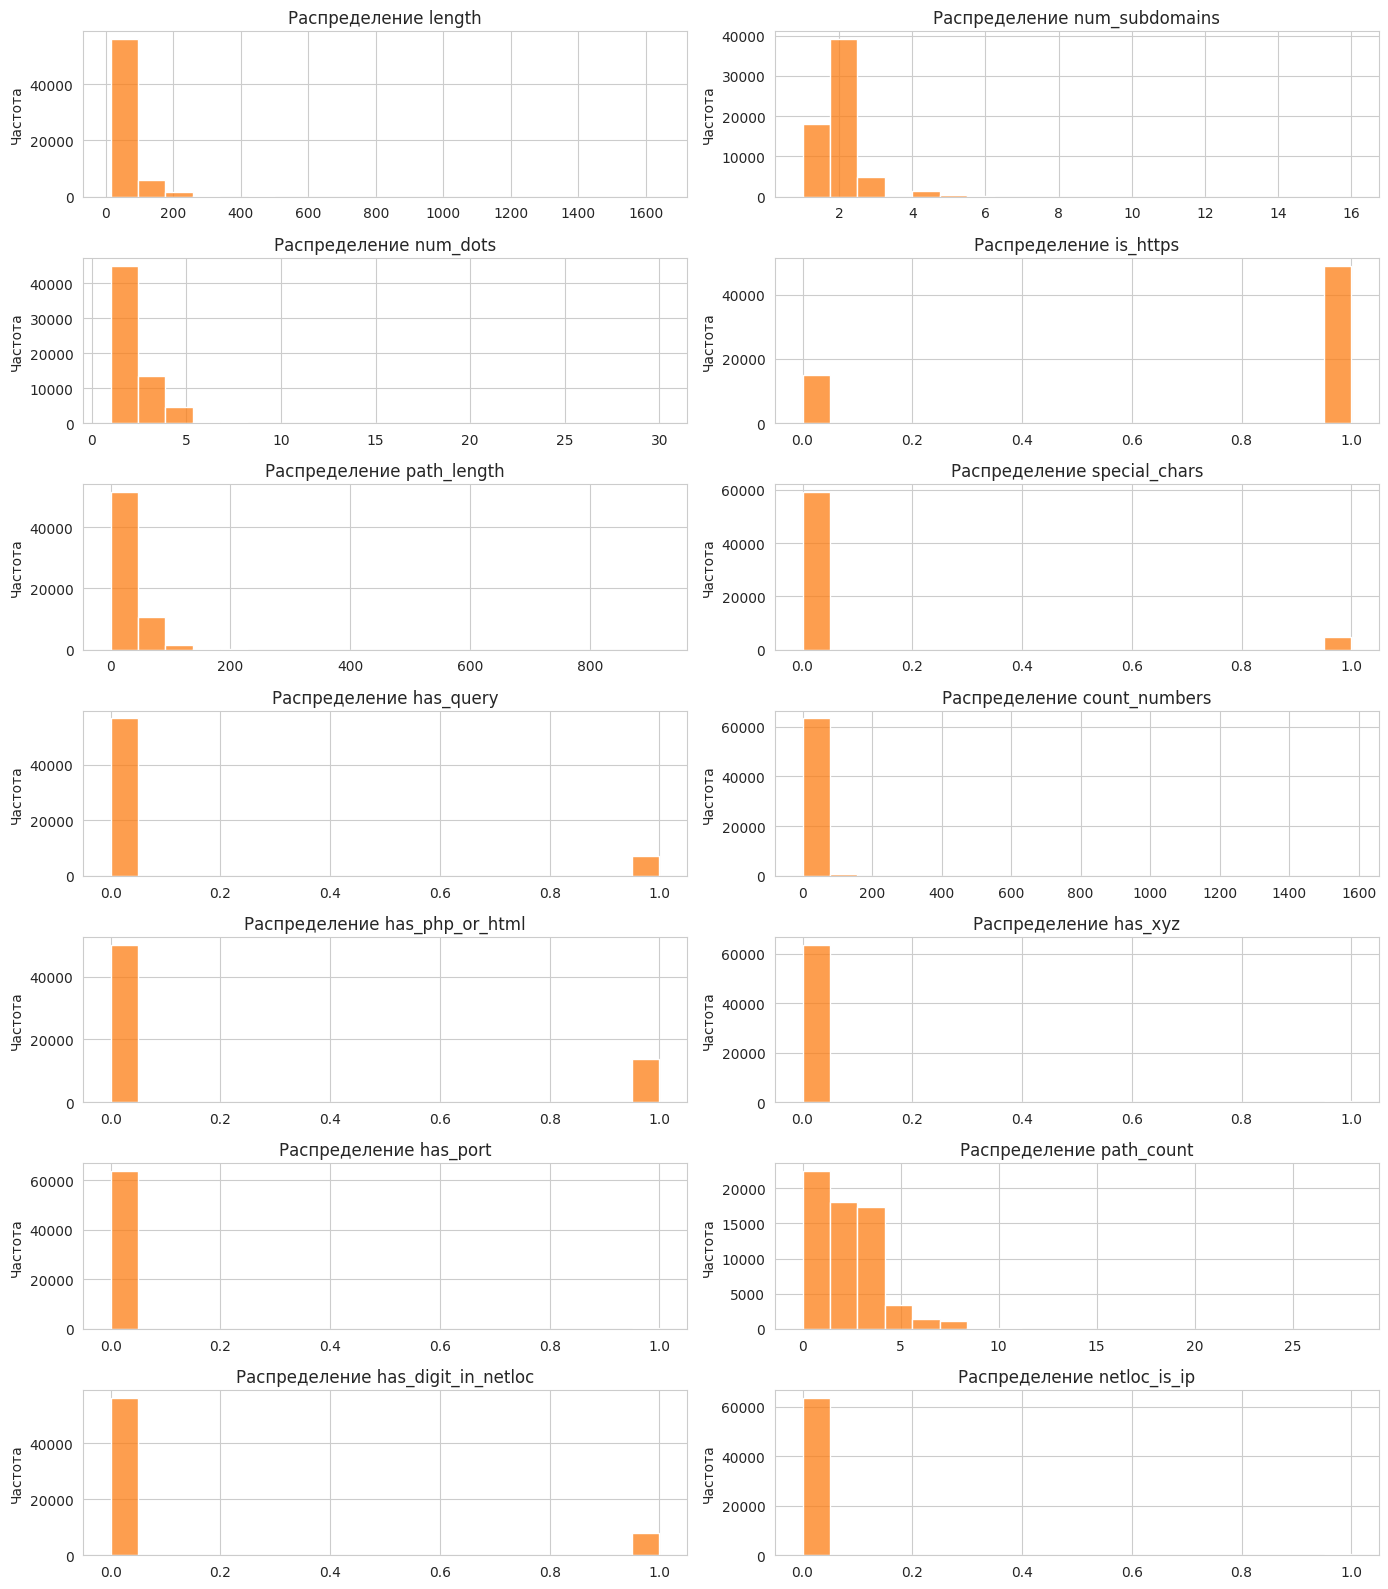

In [13]:
set_palette(color_palette(colors))

fig, axes = plt.subplots(7, 2, figsize=(14, 16))
axes = axes.flatten()

feature_names = features_dataframe.columns
for i, feature in enumerate(feature_names):
    histplot(features_dataframe[feature], bins=20, ax=axes[i])
    axes[i].set_title(f'Распределение {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [14]:
features_dataframe.head()

,length,num_subdomains,num_dots,is_https,path_length,special_chars,has_query,count_numbers,has_php_or_html,has_xyz,has_port,path_count,has_digit_in_netloc,netloc_is_ip
0,36,2,2,1,1,0,0,7,0,0,0,1,1,0
1,24,2,2,1,1,0,0,0,0,0,0,1,0,0
2,67,2,3,0,48,0,0,0,1,0,0,2,0,0
3,27,3,3,1,0,0,0,0,0,1,0,0,0,0
4,62,2,3,0,36,0,0,0,0,0,0,2,0,0


In [15]:
features_dataframe.describe()

,length,num_subdomains,num_dots,is_https,path_length,special_chars,has_query,count_numbers,has_php_or_html,has_xyz,has_port,path_count,has_digit_in_netloc,netloc_is_ip
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,63.905187,1.859531,2.309125,0.767016,27.050203,0.075031,0.114766,5.205922,0.217828,0.006703,0.007328,2.386672,0.121859,0.005375
std,53.502444,0.714511,1.480480,0.422736,27.725231,0.263444,0.318741,20.577868,0.412773,0.081598,0.085291,1.610661,0.327126,0.073118
min,14.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,1.000000,2.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,51.000000,2.000000,2.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
75%,73.000000,2.000000,3.000000,1.000000,39.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
max,1641.000000,16.000000,30.000000,1.000000,916.000000,1.000000,1.000000,1579.000000,1.000000,1.000000,1.000000,28.000000,1.000000,1.000000


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    features_dataframe.to_numpy(),
    y,
    random_state=42,
    test_size=0.2,
    shuffle=True
)

In [41]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
y_pred = model.predict(X_test)


    Accuracy:   0.887109375,
    F1:         0.8460637051241078,
    Precision:  0.8630732449467508,
    Recall:     0.8297116590054325,
    


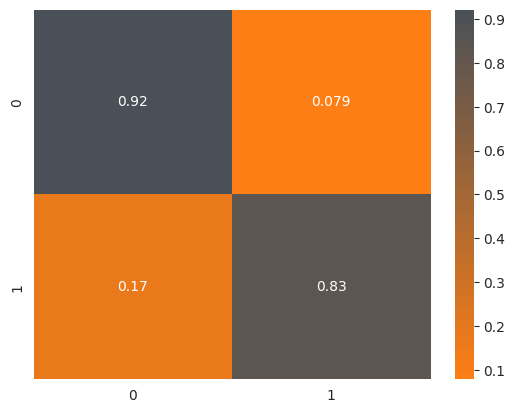

In [43]:
print(f'''
    Accuracy:   {accuracy_score(y_pred=y_pred, y_true=y_test)},
    F1:         {f1_score(y_pred=y_pred, y_true=y_test)},
    Precision:  {precision_score(y_pred=y_pred, y_true=y_test)},
    Recall:     {recall_score(y_pred=y_pred, y_true=y_test)},
    '''
)

heatmap(confusion_matrix(y_pred=y_pred, y_true=y_test, normalize='true'), annot=True, cmap=gradient_cmap);

In [44]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      8014
           1       0.86      0.83      0.85      4786

    accuracy                           0.89     12800
   macro avg       0.88      0.88      0.88     12800
weighted avg       0.89      0.89      0.89     12800



In [45]:
test = pd.read_csv("test.csv")

In [46]:
test_features_dataframe = parse_url_features(test["url"])

100%|██████████| 16000/16000 [00:00<00:00, 24817.26it/s]


In [47]:
y_pred_submition = model.predict(test_features_dataframe.values)

In [48]:
submit = pd.read_csv("sample_submit.csv")

In [49]:
submit["Predicted"] = y_pred_submition
submit

,Id,Predicted
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
15995,15995,0
15996,15996,0
15997,15997,0
15998,15998,0


In [50]:
submit.to_csv("sample_submit.csv", index=False)